In [24]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [517]:
%matplotlib inline

def set_plot_defaults():

    multiplikator = 0.5

    plt.rcParams['axes.linewidth'] = 2 * multiplikator # set the value globally
    plt.rcParams['xtick.major.size'] = 5 * multiplikator
    plt.rcParams['xtick.major.width'] = 2 * multiplikator
    plt.rcParams['xtick.minor.size'] = 10 * multiplikator
    plt.rcParams['xtick.minor.width'] = 2 * multiplikator
    plt.rcParams['ytick.major.size'] = 5 * multiplikator
    plt.rcParams['ytick.major.width'] = 2 * multiplikator
    plt.rcParams['ytick.minor.size'] = 10 * multiplikator
    plt.rcParams['ytick.minor.width'] = 2 * multiplikator

    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['figure.dpi'] = 300 
    plt.gcf().subplots_adjust(wspace=0, hspace=0.3)

    font_size = 18

    params = {'axes.labelsize': font_size,
              'axes.titlesize': font_size,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size}

    plt.rcParams.update(params)
    sns.set_style('ticks')
    
set_plot_defaults()

<Figure size 3600x2400 with 0 Axes>

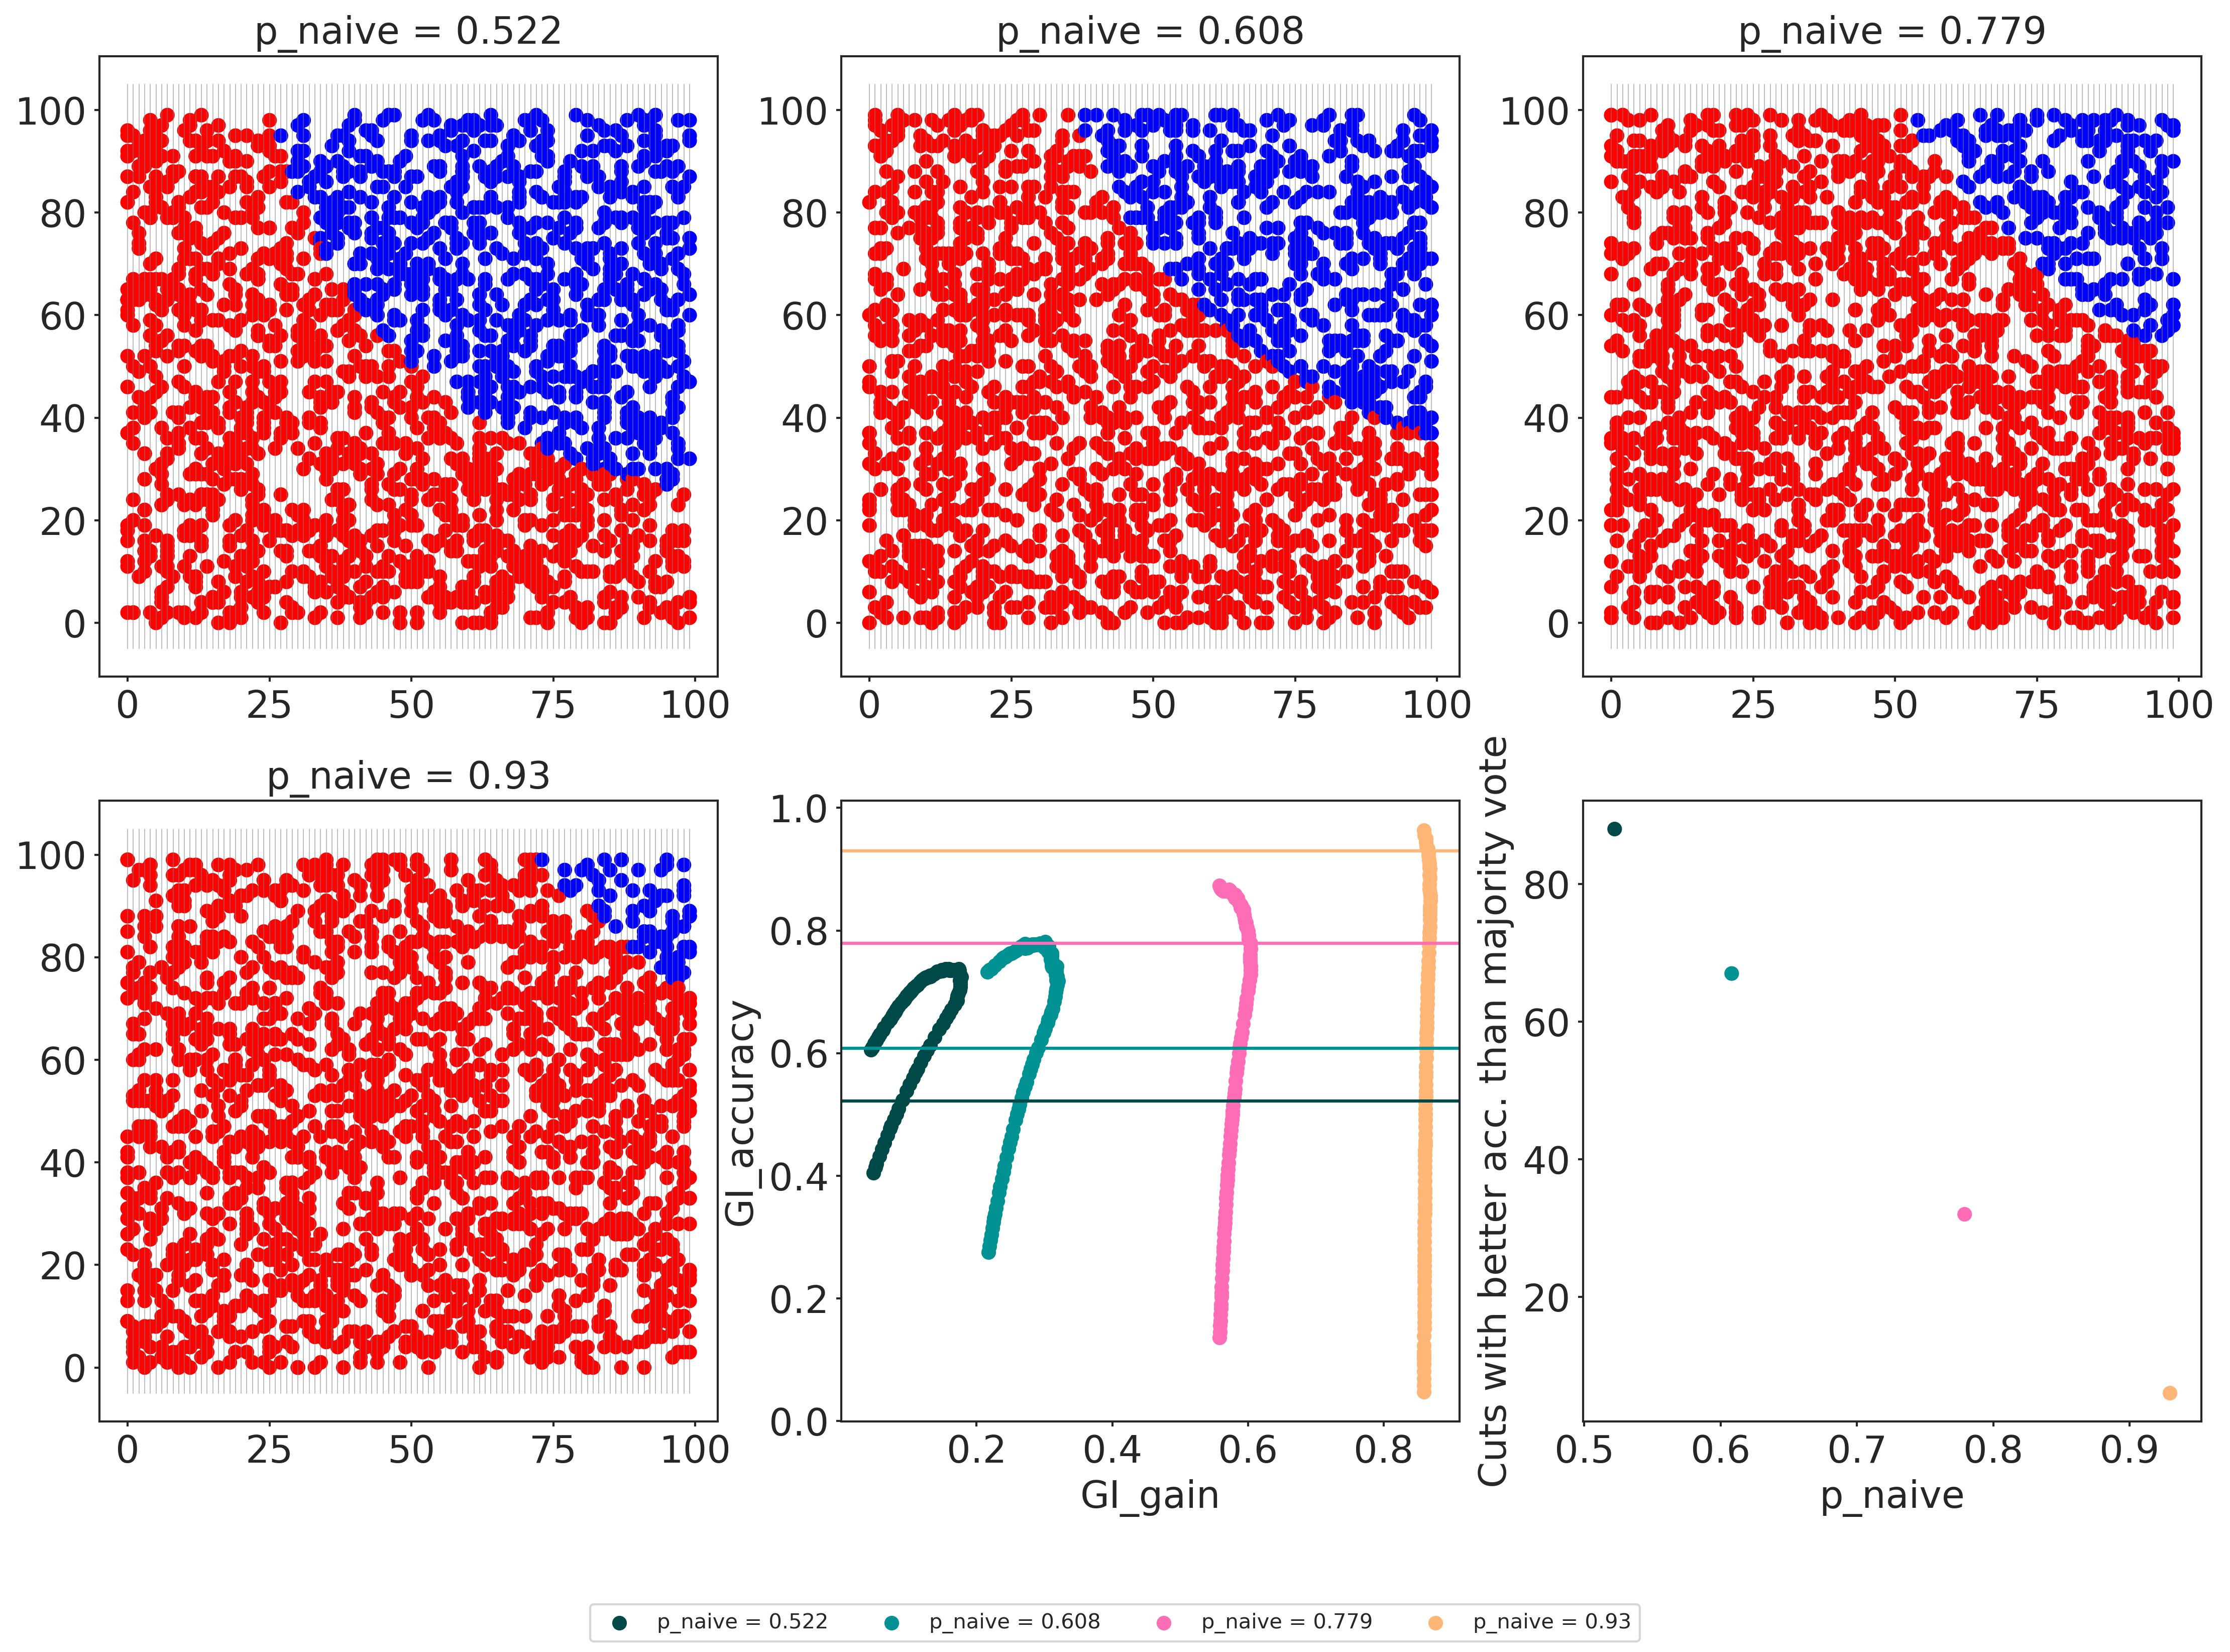

In [519]:
n_points = 2000
n_cuts = 100
js = [50, 60, 72, 85]
somsault_1_rgba = (  0,   0,   0, 255)
somsault_2_rgba = (  0/255,  73/255,  73/255, 255/255)
somsault_3_rgba = (  0/255, 146/255, 146/255, 255/255)
somsault_4_rgba = (255/255, 109/255, 182/255, 255/255)
somsault_5_rgba = (255/255, 182/255, 119/255, 255/255)
colors = [somsault_2_rgba, somsault_3_rgba, somsault_4_rgba, somsault_5_rgba]

n_y = 2 # rows
n_x = 3 # columns

panel_pos = [[0,0], [0,1], [0,2],
             [1,0], [1,1], [1,2]] 

fig, axs = plt.subplots(n_y, n_x)
fig.set_size_inches(18, 12)

js_dependency = pd.DataFrame()

for l in range(0, len(js)):

    p_x = sorted([random.randint(0, 99) for p in range(0, n_points)])
    p_y = [random.randint(0, 99) for p in range(0, n_points)]

    data = pd.DataFrame({"p_x": p_x,
                         "p_y": p_y})

    classes = np.sqrt((data.p_x*data.p_y))
    data["truth"] = ["blue" if x > js[l] else "red" for x in classes]

    pos_counter = l
    pos_x = panel_pos[pos_counter][0]
    pos_y = panel_pos[pos_counter][1]
    axs[pos_x, pos_y].scatter(x=data.p_x, 
                              y=data.p_y, 
                              c=data.truth,
                              alpha=1)

    # randomly draw lines for splits
    # x_coords = sorted([random.randint(0, 99) for p in range(0, n_cuts)])
    x_coords = range(0, n_cuts, 1)

    for x_coord in x_coords:

        axs[pos_x, pos_y].plot([x_coord, x_coord], 
                               [-5, 105], 
                               color="grey", 
                               linestyle='-', 
                               linewidth=0.5,
                               alpha=0.5)

        correct = ["blue" if x > x_coord else "red" for x in p_x]
        data = pd.concat([data, pd.DataFrame({"x@"+str(x_coord):correct})], axis=1)

    cuts = pd.DataFrame()    

    for c in data.columns:

        if "@" in c:

            x_cutoff = int(c[2:])

            ########################################################################
            # Count left side of split

            left = data[data.p_x <= x_cutoff]
            left_counts = {"red": 0, "blue": 0}

            tmp = left["truth"].value_counts().to_dict()

            for k in tmp:

                left_counts[k] = tmp[k]

            n_red = left_counts["red"]
            n_blue = left_counts["blue"]

            if (n_red > 0 and n_blue > 0):

                n_red_p = (n_red / (n_red + n_blue))
                n_blue_p = (n_blue / (n_red + n_blue))
                gi_left = (n_red_p * (1-n_red_p)) + (n_blue_p * (1-n_blue_p)) 

            else:

                gi_left = 0

            n_left = n_red + n_blue

            ########################################################################
            # Count right side of split

            right = data[data.p_x > x_cutoff]
            right_counts = {"red": 0, "blue": 0}

            tmp = right["truth"].value_counts().to_dict()

            for k in tmp:

                right_counts[k] = tmp[k]

            n_red = right_counts["red"]
            n_blue = right_counts["blue"]

            if (n_red > 0 and n_blue > 0):

                n_red_p = (n_red / (n_red + n_blue))
                n_blue_p = (n_blue / (n_red + n_blue))
                gi_right = (n_red_p * (1-n_red_p)) + (n_blue_p * (1-n_blue_p)) 

            else:

                gi_right = 0

            n_right = n_red + n_blue

            ########################################################################
            # Calculate true positives for accuracy

            counts = {"True": 0, "False": 0}

            tmp = (data.truth == data[c]).value_counts().to_dict()

            for k in tmp:

                counts[str(k)] = tmp[k]

            acc = counts["True"] / n_points

            ########################################################################
            # Add split to result df

            cuts = pd.concat([cuts, pd.DataFrame({"x": [x_cutoff], 
                                                  "n_left": [n_left],
                                                  "GI_left": [gi_left], 
                                                  "n_right": [n_right],
                                                  "acc": [acc],
                                                  "GI_right": [gi_right]})])

    ################################################################################
    # Calculate naive probability

    p_naive = sum((data.truth.value_counts()/n_points)**2)
    axs[pos_x, pos_y].set_title("p_naive = " + str(np.round(p_naive, 3)))
    
    ################################################################################
    # Calculate weighted Gini Impurity

    GI_w = []
    GI_gainz = []
    GI_accuracies = []

    for _, cut in cuts.iterrows():

        GI_weighted = (cut.n_left/(cut.n_left + cut.n_right)) * cut.GI_left + \
                      (cut.n_right/(cut.n_left + cut.n_right)) * cut.GI_right

        GI_w.append(GI_weighted)
        GI_gainz.append(p_naive-GI_weighted)

    cuts["GI_weighted"] = GI_w
    cuts["GI_gain"] = GI_gainz

#     print(cuts.sort_values("GI_gain").tail(3))

    axs[1, 1].scatter(cuts.GI_gain, 
                      cuts.acc, 
                      color=colors[l], 
                      label="p_naive = " + str(np.round(p_naive, 3)))
    axs[1, 1].set_xlabel("GI_gain")
    axs[1, 1].set_ylabel("GI_accuracy")
    axs[1, 1].axhline(y=p_naive, 
                color=colors[l], 
                linestyle="-")
    
    n_above = len(cuts.loc[cuts.acc > p_naive].acc)
    
    js_dependency = pd.concat([js_dependency, pd.DataFrame({"p_naive": [p_naive],
                                                            "n_above": [n_above]})])
    
    
    
axs[1, 2].scatter(js_dependency.p_naive, js_dependency.n_above, color=colors)
axs[1, 2].set_xlabel("p_naive")
axs[1, 2].set_ylabel("Cuts with better acc. than majority vote")
    
handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4)


plt.savefig("/shared_data/google-drive/Projekte/stackoverflow_answers/gini-impurity-in-decision-tree-reasons-to-use-it.png")  